# Starbucks App Customer Rewards Program Analysis

In [ ]:
import os 

# Set the working directory
os.chdir('...')

For this project, I am using data from https://www.kaggle.com/datasets/blacktile/starbucks-app-customer-reward-program-data/data

The Starbucks dataset exists as three separate JSON files:

- portfolio.json - information about promotional offers 
- profile.json - customers demographics
- transcript.json - customer interactions logs

#### Objective
The objective of this project is to gain an understanding of the structure of Starbucks' customer base and identify key factors that influence offer completion. By analyzing customer demographics and purchasing behavior, the goal is to generate insights that can help optimize marketing strategies and enhance customer engagement with the rewards program.

In [4]:
# Load the necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Cleaning and Preparation

#### Load and Explore Profile Data

In [5]:
# Load customer profile data
profile = pd.read_json("profile.json", lines=True)

# Display first few rows
print(profile.head())

  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN


In [6]:
# Check dataset structure 
profile.shape

(17000, 5)

Our data consists of 17,000 unique customers, their gender, age, date of membership, and income

In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
# Ensure the column is in datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [9]:
# Check unique values per column
profile.nunique()

gender                  3
age                    85
id                  17000
became_member_on     1716
income                 91
dtype: int64

In [10]:
# Inspect 'gender' column
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [11]:
# Replace 'O' in gender with None
profile['gender'] = profile['gender'].replace({'O': None})

In [12]:
# Check for missing values
profile.isnull().sum()

gender              2387
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

I chose to remove missing values because, with 17,000 observations, we still have a large enough dataset for meaningful analysis while ensuring data consistency.

In [13]:
# Drop missing values and reset index
profile = profile.dropna().reset_index(drop=True)

In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14613 entries, 0 to 14612
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14613 non-null  object        
 1   age               14613 non-null  int64         
 2   id                14613 non-null  object        
 3   became_member_on  14613 non-null  datetime64[ns]
 4   income            14613 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 570.9+ KB


#### Load and Explore Portfolio Data

In [15]:
# Load promotional offer data
portfolio = pd.read_json("portfolio.json", lines=True)

# Display first few rows
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [16]:
portfolio.shape

(10, 6)

In [18]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


The portfolio dataset contains information about different promotional offers sent to customers. Each offer has attributes like offer id, type, duration, difficulty, reward, as well as the channels used. Notice that the channels column contains lists, so we will convert it into separate binary columns. Also there are multiple offers with the same offer type (e.g. bogo) that have different difficulty, duration and reward. For the purpose of this project, we will not consider duration, difficulty and reward separately, but we will modify offer_type by appending difficulty and duration for better identification.

In [19]:
# Convert 'channels' list column into binary columns
channels_dummies = portfolio['channels'].explode().str.get_dummies().groupby(level=0).max()
portfolio = portfolio.join(channels_dummies).drop(columns=['channels'])

In [20]:
# Create a more descriptive 'offer_type'
portfolio['offer_type'] = portfolio['offer_type'] + "-" + portfolio['difficulty'].astype(str)
portfolio['offer_type'] = portfolio['offer_type'] + "-" + portfolio['duration'].astype(str)

In [21]:
# Create unique identifiers for offer channel combinations
portfolio['channel_group'] = pd.factorize(portfolio[['email', 'mobile', 'social', 'web']].apply(tuple, axis=1))[0] + 1

In [23]:
# Check for missing values
portfolio.isnull().sum()

reward           0
difficulty       0
duration         0
offer_type       0
id               0
email            0
mobile           0
social           0
web              0
channel_group    0
dtype: int64

In [24]:
portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,channel_group
0,10,10,7,bogo-10-7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1
1,10,10,5,bogo-10-5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,2
2,0,0,4,informational-0-4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,3
3,5,5,7,bogo-5-7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,3
4,5,20,10,discount-20-10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,4


#### Load and Explore Transcript Data

In [25]:
# Load transaction data
transcript = pd.read_json("transcript.json", lines=True)

# Display first few rows
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [27]:
transcript.shape

(306534, 4)

This dataset includes the data about all the customers interactions. We notice that 'value' column consists of dictionaries. We will first analyze the unique keys from the 'event' and 'value' columns before transforming this dataset into the structure that fits our analysis.   

In [28]:
unique_keys = set().union(*transcript['value'].apply(lambda x: x.keys()))
print(unique_keys)

{'reward', 'offer id', 'offer_id', 'amount'}


In [29]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

We observe that the dataset contains multiple event types, each storing different types of information in the 'value' column as key-value pairs. Since these events represent distinct interactions (such as receiving, viewing, or completing an offer), we will pivot the 'event' column so that each event type becomes its own separate column, populated with relevant values from the corresponding key-value pairs.

In [30]:
# Pivot the 'event' column
transcript_pivoted = transcript.pivot_table(index=['person', 'time'],  # Keep 'person' and 'time' as row identifiers
                                            columns='event',  # Events become columns
                                            values='value',  # Keep 'value' as the data
                                            aggfunc='first').reset_index()  # Use first non-null value if duplicates exist and resent index

In [31]:
# Extract 'amount' value in 'transaction' column and replace NaN with 0.0
transcript_pivoted['transaction'] = transcript_pivoted['transaction'].apply(
    lambda x: x['amount'] if isinstance(x, dict) else 0.0)

In [32]:
# Extract 'offer_id' value in 'offer completed' column keeping NaNs
transcript_pivoted['offer completed'] = transcript_pivoted['offer completed'].apply(
    lambda x: x.get('offer_id') if isinstance(x, dict) else x)

In [33]:
# Extract 'offer id' value in 'offer received' and 'offer viewed' columns keeping NaNs
columns_to_extract = [ 'offer received', 'offer viewed']  
for col in columns_to_extract:
    transcript_pivoted[col] = transcript_pivoted[col].apply(lambda x: x.get('offer id') if isinstance(x, dict) else x)

In [34]:
transcript_pivoted.head()

event,person,time,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0.00
1,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.00
2,0009655768c64bdeb2e877511632db8f,228,NaN,NaN,NaN,22.16
3,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0.00
4,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.00


#### Merge the dataframes

Now that we explored and pre-processed our datasets, we can aggregate customers data and transactional data before we proceed to analyzing customer base and their interactions with Reward Program offers. 

In [35]:
# Group by 'person' to get total amount spent, number of transactions, and offer interactions for each customer
customer_summary = transcript_pivoted.groupby('person', as_index=False).agg(
    total_offers_received=('offer received', 'count'),
    total_offers_viewed=('offer viewed', 'count'),
    total_offers_completed=('offer completed', 'count'),
    amount_spent=('transaction', 'sum'),
    num_of_transactions=('transaction', lambda x: (x != 0).sum()))

In [36]:
customer_summary.head()

,person,total_offers_received,total_offers_viewed,total_offers_completed,amount_spent,num_of_transactions
0,0009655768c64bdeb2e877511632db8f,5,4,3,127.60,8
1,00116118485d4dfda04fdbaba9a87b5c,2,2,0,4.09,3
2,0011e0d4e6b944f998e987f904e8c1e5,5,5,2,79.46,5
3,0020c2b971eb4e9188eac86d93036a77,5,3,2,196.86,8
4,0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,154.05,12


In [37]:
# Merge aggregated customer data with profile data
customers = profile.merge(
    customer_summary,
    left_on='id',  # Match customer IDs
    right_on='person',  
    how='left'  # Keep all rows from profile, adding matches from customer_summary
).drop(columns=['person'])  # Drop redundant 'person' column

In [38]:
# Compute the offer completion rate to better understand how engaged a customer is with promotional offers
customers['offer_complete_rate_%'] = ((customers['total_offers_completed'] / customers['total_offers_received']) * 100).round(2)

# Fill NaN values (which appear if total_offers_received is 0) with 0
customers['offer_complete_rate_%'] = customers['offer_complete_rate_%'].fillna(0)

In [39]:
# Rename 'id' column to 'customer_id'
customers = customers.rename(columns={'id': 'customer_id'})

In [40]:
# Convert 'M' to 1 and 'F' to 0
customers['gender'] = customers['gender'].map({'M': 1, 'F': 0})

In [41]:
customers.head()


,gender,age,customer_id,became_member_on,income,total_offers_received,total_offers_viewed,total_offers_completed,amount_spent,num_of_transactions,offer_complete_rate_%
0,0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2,0,1,77.01,3,50.00
1,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,4,4,2,159.27,7,50.00
2,1,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,4,3,1,57.73,3,25.00
3,1,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,6,6,3,36.43,3,50.00
4,1,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,3,2,1,15.62,4,33.33


In [44]:
# Check for missing values
customers.isna().sum()

gender                    0
age                       0
customer_id               0
became_member_on          0
income                    0
total_offers_received     0
total_offers_viewed       0
total_offers_completed    0
amount_spent              0
num_of_transactions       0
offer_complete_rate_%     0
dtype: int64

In [45]:
customers.describe()

,gender,age,became_member_on,income,total_offers_received,total_offers_viewed,total_offers_completed,amount_spent,num_of_transactions,offer_complete_rate_%
count,14613.000000,14613.000000,14613,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000
mean,0.580579,54.393417,2017-02-18 00:12:54.543215104,65435.707931,4.488127,3.359132,1.992815,116.922320,8.360775,44.610530
min,0.000000,18.000000,2013-07-29 00:00:00,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,42.000000,2016-05-19 00:00:00,49000.000000,4.000000,2.000000,1.000000,31.350000,5.000000,20.000000
50%,1.000000,55.000000,2017-08-02 00:00:00,64000.000000,5.000000,3.000000,2.000000,86.770000,7.000000,50.000000
75%,1.000000,66.000000,2017-12-30 00:00:00,80000.000000,5.000000,4.000000,3.000000,160.770000,11.000000,66.670000
max,1.000000,101.000000,2018-07-26 00:00:00,120000.000000,6.000000,6.000000,6.000000,1608.690000,36.000000,100.000000
std,0.493481,17.400201,NaN,21633.524110,1.073955,1.290038,1.448454,130.125954,5.181737,30.933789


The age distribution ranges from 18 to 101 years, with a median of 55 years, indicating a slightly older population among the reward program users. The income distribution varies between $30,000 and $120,000, with a median of $64,000. The standard deviations of 17 for age and 21,633 for income indicate a relatively broad range of ages and income levels. 

The distribution of total offers received, viewed, and completed as well as offer completion rate shows variation across customers, with some receiving multiple offers and engaging with them, while others have zero interactions.

Spending and transaction behavior also vary significantly. The average amount spent is around 116.92, but individual values span a wide range, suggesting that some customers spend significantly more than others. The number of transactions per customer follows a similar pattern, with an average of around 8.36, but some customers have no transactions recorded. The standard deviations across these features suggest considerable variability, meaning that a small group of high-spending and highly engaged customers may be driving the overall averages.

We have customers who have been participating in the rewards program for a long time, and some newer customers, with the majority being part of the program for around a year. Although distinguishing between old and new customers could provide valuable insights, in this project I will focus on demographics, purchasing behavior and engagement with the brand, leaving membership date for potential future analysis. 

We will now proceed with exploratory data analysis (EDA) and plot the histograms to understand the distribution of numerical variables in our dataset. 

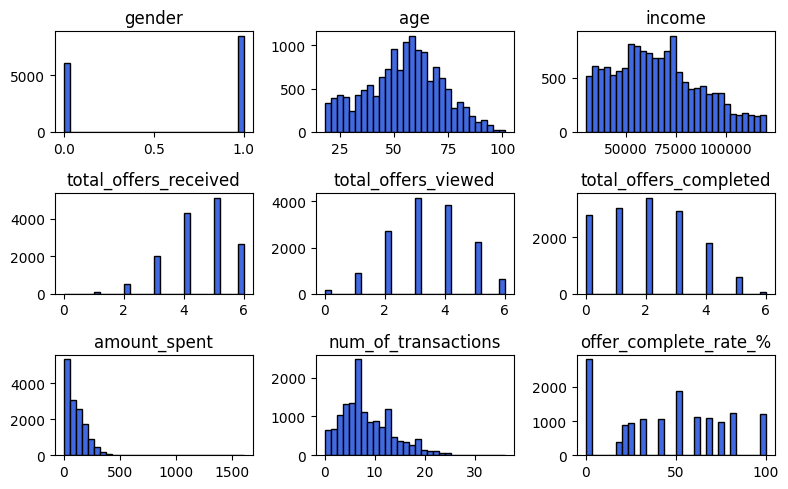

In [46]:
numerical_cols = customers.select_dtypes('number').columns

fig = customers[numerical_cols].hist(bins=30, figsize=(8, 5), edgecolor='black', color='royalblue')
for ax in fig.flatten():
    ax.grid(False)  
plt.tight_layout()
plt.show()

From the distribution of gender we see that there are more male customers. The distribution of age appears relatively normal, with a peak around 50-60 years old, suggesting a large middle-aged customer base.
The distribution of income is slightly skewed right, with more people earning between $50,000 and $80,000. 
The distribution of amount spent is heavily skewed to the right, with most customers spending smaller amounts, but a few are high-spenders. 
Looking at the distributions of total offers received, viewed, and completed we can definitely notice a pattern where the number of offers received is higher than the number of offers viewed, which is higher than the number of offers completed.
Number of transactions follows a right-skewed distribution, with most customers making a small number of transactions, but some making significantly more. 
The distribution of offer completin rate is spread out, with many customers completing offers at varying rates.

Next, we will further explore relationships between numerical variables in our dataset using seaborn's pairplot function for pairwise comparisons between variables. On the diagonal, we use kernel density estimates (KDE) to visualize the distribution of each individual variable, while the off-diagonal plots display scatterplots, allowing us to examine potential correlations and patterns. 

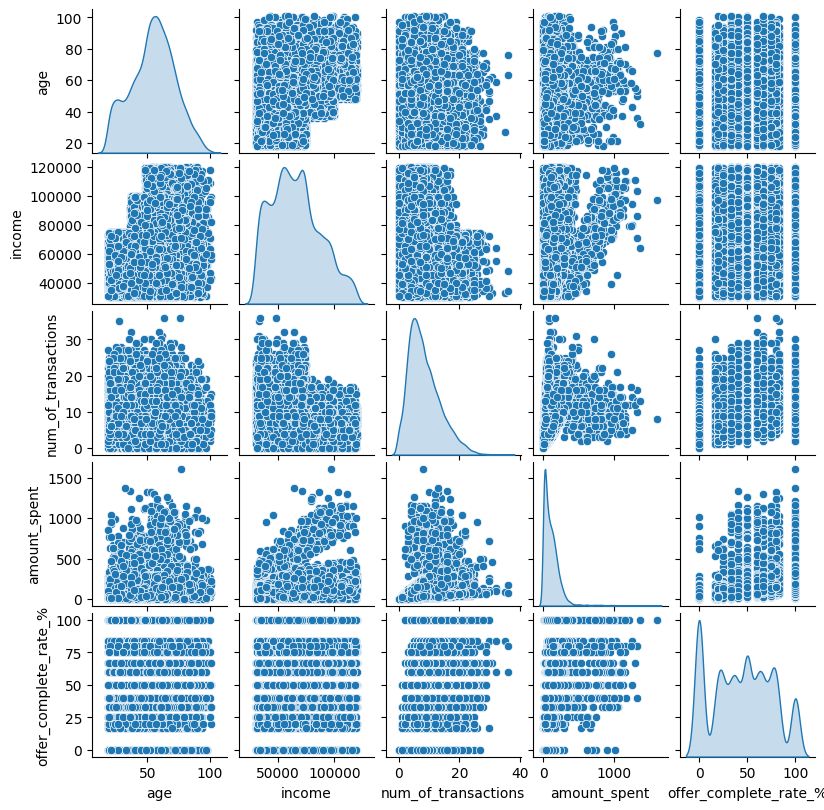

In [47]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Select numerical columns for pairplot
selected_columns = ['age', 'income', 'num_of_transactions', 'amount_spent', 'offer_complete_rate_%']
# Create pairplot and set figure size
pairplot = sns.pairplot(customers[selected_columns], diag_kind="kde")
pairplot.fig.set_size_inches(8, 8)
plt.show()

The scatter plots exhibit a high degree of variability across feature relationships, highlighting the complexity of customer behavior and the absence of a single dominant pattern. Individuals with varying ages, income levels, and transaction counts demonstrate similar spending behaviors, suggesting that multiple factors contribute to purchasing decisions rather than any single characteristic.

From the kernel density estimates we notice that age, income and offer completion rate exhibit a multimodal distribution. This suggests that we may have distinct subgroups within our customer base related to demographics or engagement behaviors. Further analysis, such as clustering, could help reveal more nuanced patterns that drive offer engagement and spending behavior.

#### K-Means Clustering

To better understand customer segmentation, we will apply K-Means clustering to identify distinct groups based on key behavioral and demographic features. By clustering customers based on these attributes, the goal is to uncover meaningful patterns that can inform targeted marketing strategies, personalized promotions, and improved customer engagement efforts.

We will use variables 'age', 'income', 'amount_spent', and 'num_of_transactions' because they are indicators of purchasing power, engagement, and spending behavior.

Age: Helps differentiate between younger and older customers who may have different spending habits and promotional preferences.

Income: Indicates financial capacity and purchasing power, which can influence spending behavior and offer responsiveness.

Amount Spent: Reflects actual customer engagement with the brand and their level of expenditure.

Number of Transactions: Provides insight into frequency of engagement, helping to distinguish between occasional and frequent shoppers.

While gender may have some correlation with spending behavior, it does not provide a continuous measure of purchasing patterns. Incorporating categorical variables like gender in K-Means, which relies on Euclidean distance, can distort clustering results. Instead, the focus is on numerical attributes that reflect demographics, purchasing behavior and customer engagement in a quantifiable way.

In [48]:
# Load the necessary packages 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [49]:
# Selecting the features
selected_features = ['age', 'income', 'amount_spent', 'num_of_transactions']
data_subset = customers[selected_features]

In [50]:
# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_subset)

In [54]:
# Finding the optimal number of clusters
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

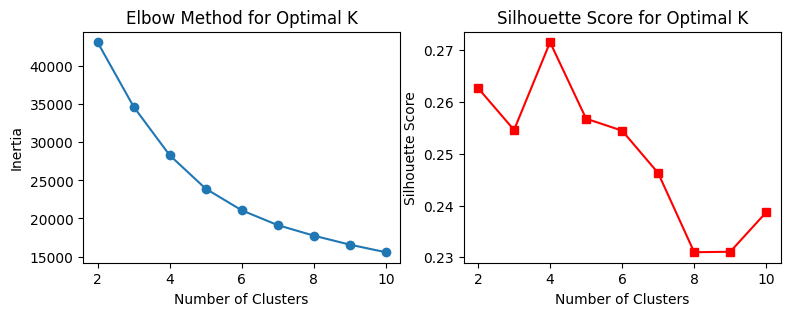

In [55]:
# Plot Elbow Method & Silhouette Score
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='s', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')

plt.show()

Based on the elbow in the inertia plot around k = 4 and the peak in the silhouette score also at k = 4, the optimal number of clusters appears to be 4.

In [51]:
# Run K-Means 
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customers['cluster'] = kmeans.fit_predict(scaled_data)

In [52]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

In [53]:
# Add PCA results to dataset
customers['pca1'] = pca_result[:, 0]
customers['pca2'] = pca_result[:, 1]

# Increment cluster labels by 1 (so they are 1-4 instead of 0-3)
customers['cluster'] = customers['cluster'] + 1 

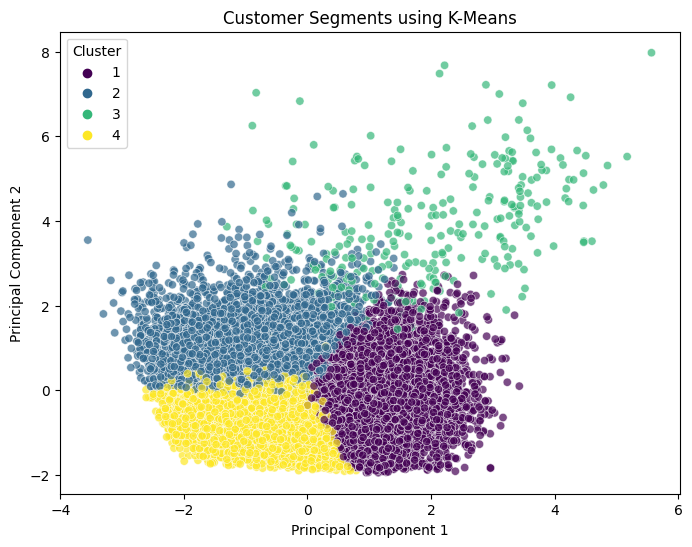

In [ ]:
# Plot Clusters in PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', palette='viridis', data=customers, alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Segments using K-Means')
plt.legend(title='Cluster')
plt.show()

Next we will generate summary statistics for each customer cluster to identify it's defining traits.

In [57]:
def cluster_summary(cluster_num):
    
    # Define columns for summary
    selected_columns = ['age', 'income', 'amount_spent', 'num_of_transactions']
    # Filter customers belonging to the given cluster
    cluster_data = customers[customers['cluster'] == cluster_num][selected_columns]
    summary = cluster_data.describe() # Generate descriptive statistics

    return summary

In [58]:
c1 = cluster_summary(1) # Cluster #1
print(c1)

               age         income  amount_spent  num_of_transactions
count  5484.000000    5484.000000   5484.000000          5484.000000
mean     65.354303   86104.121080    134.969185             6.236506
std      12.475623   15450.907393     80.425682             3.236055
min      36.000000   39000.000000      0.000000             0.000000
25%      56.000000   75000.000000     76.397500             4.000000
50%      64.000000   85000.000000    127.350000             6.000000
75%      74.000000   97000.000000    185.002500             8.000000
max     101.000000  120000.000000    443.310000            17.000000


We can categorize this group as Occasional Moderate Spenders. This group is composed of older, financially stable individuals who make occasional visits and spend moderately when they shop. 

In [59]:
c2 = cluster_summary(2) # Cluster #2
print(c2)

               age         income  amount_spent  num_of_transactions
count  3679.000000    3679.000000   3679.000000          3679.000000
mean     47.956510   52717.042675    144.857222            15.202501
std      17.337085   13567.269829     93.116548             3.861317
min      18.000000   30000.000000     15.290000             6.000000
25%      34.000000   41000.000000     60.660000            12.000000
50%      48.000000   53000.000000    136.070000            14.000000
75%      60.000000   63000.000000    199.140000            17.000000
max     101.000000  100000.000000    503.950000            36.000000


We can categorize this group as High-Engagement Moderate Spenders. These are mid-aged customers with modest incomes who engage actively with frequent purchases. While their spending per visit remains moderate, the high transaction count shows consistent shopping behavior.

In [61]:
c3 = cluster_summary(3) # Cluster #3
print(c3)

              age         income  amount_spent  num_of_transactions
count  288.000000     288.000000    288.000000           288.000000
mean    56.864583   76267.361111    773.934618            10.642361
std     16.671004   19550.917459    216.675239             4.678576
min     18.000000   34000.000000    447.730000             2.000000
25%     47.000000   60000.000000    600.505000             7.000000
50%     58.000000   73000.000000    743.410000            10.000000
75%     67.250000   91000.000000    935.437500            13.000000
max     97.000000  119000.000000   1608.690000            30.000000


We can categorize this group as Premium Frequent Shoppers. These are older, higher-income individuals who make regular visits and spend significantly per transaction. Their behavior suggests strong purchasing capacity and a high level of engagement.

In [62]:
c4 = cluster_summary(4) # Cluster #4
print(c4)

               age        income  amount_spent  num_of_transactions
count  5162.000000   5162.000000   5162.000000          5162.000000
mean     47.198566  51938.395971     41.184029             5.614103
std      15.902188  12688.298163     39.380192             2.655703
min      18.000000  30000.000000      0.000000             0.000000
25%      35.000000  41000.000000     13.262500             4.000000
50%      48.000000  52000.000000     24.780000             6.000000
75%      59.000000  62000.000000     62.695000             8.000000
max      97.000000  92000.000000    443.580000            11.000000


We can categorize this group as Infrequent Budget Shoppers. Representing a younger-to-mid-age group with lower income levels, these customers shop infrequently and make low-cost purchases. Their shopping activity is minimal, with limited spend across few visits.

#### Engagement in Customer Rewards Program 

Now that we have identified our customer groups, we can move forward with analyzing how customers respond to different offers both overall and within each customer segment. 

Why analyzing customers' engagement in the rewards program is important? To answer this question we will test the following hypothesis:

Null: There is no association between amount spent and number of offers completed.

Alternative: There is an association between amount spent and number of offers completed.

In [63]:
import scipy.stats as stats

# Compute Spearman correlation coefficient and p-value
spearman_corr, spearman_p = stats.spearmanr(customers['amount_spent'], customers['total_offers_completed'])

# Display the results
print(f"Spearman Correlation: {spearman_corr:.4f}")
print(f"P-value: {spearman_p:.4f}")

Spearman Correlation: 0.7842
P-value: 0.0000


We examined the relationship between amount spent and total offers completed using the Spearman's rank correlation coefficient, which assesses the strength and direction of a monotonic relationship between two variables. This non-parametric measure is appropriate given the skewness in spending and the non-linear nature of the relationship between our variables. 

The analysis yielded a strong positive correlation (0.7842) with a statistically significant p-value (0.0000). We reject the null hypothesis and can say that there is a statistically significant monotonic relationship between the number of offers completed and the total amount spent. 
 This indicates that customers who complete more offers tend to spend more, highlighting the importance of promoting rewards program participation to drive increased revenue.

We will merge the 'transcript' dataset, which contains detailed records of individual offer interactions, with our customers dataset. This will allow us to track which offers were sent to each customer and how they responded. By analyzing this data, we can see if certain offer types or channels through which offers are sent have higher success rates than the others, enabling a deeper understanding of offer effectiveness.

In [64]:
# Extract 'value' from dictionary entries in 'value' column
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0] if isinstance(x, dict) else x)

completed = transcript[transcript['event'] == 'offer completed'].copy() # Filter where 'event' == 'offer completed'
received = transcript[transcript['event'] == 'offer received'].copy() # Filter where 'event' == 'offer received'
received = received[['person', 'value']].copy() # Keep only 'person' and 'value' columns
received.rename(columns={'value': 'offer_id'}, inplace=True)# Rename 'value' to 'offer_id'

In [65]:
# Count how many times each person completed a specific offer_id
counts = completed.groupby(['person', 'value']).size().reset_index(name='count')

In [66]:
# Merge offers_received with counts on person and offer_id. Match each received offer with how many times it was completed
offers_merged = received.merge(counts, 
    left_on=['person', 'offer_id'], 
    right_on=['person', 'value'], 
    how='left')

In [67]:
# Create 'offer_completed' column with 0s initially
offers_merged['offer_completed'] = 0

# Assign '1' exactly as many times as this offer appears in 'completed' for a specific person
for index, row in offers_merged.iterrows():
    if row['count'] > 0:  # Check if this person-offer_id exists in 'completed'
        offers_merged.at[index, 'offer_completed'] = 1  # Assign 1 
        offers_merged.at[index, 'count'] -= 1  # Reduce the remaining count

offers_merged.drop(columns=['value', 'count'], inplace=True) # Drop extra columns

In [68]:
# Merge with portfolio using offer ID
offers = offers_merged.merge(
    portfolio[['id', 'offer_type', 'channel_group', 'email', 'mobile', 'social', 'web']], 
    left_on='offer_id', 
    right_on='id', 
    how='left')

offers.drop(columns=['id'], inplace=True) # Drop redundant column

In [69]:
# Merge customers dataset with offers on 'person' column
offers = offers.merge(
    customers[['customer_id', 'gender', 'age', 'income', 'amount_spent', 
               'num_of_transactions', 'offer_complete_rate_%', 'cluster']], 
    left_on='person', 
    right_on='customer_id', 
    how='left').dropna()

offers.drop(columns=['person'], inplace=True) # Drop redundant column

In [70]:
# Remove rows where 'offer_type' contains 'informational'
offers = offers[~offers['offer_type'].str.contains('informational')]

Since the purpose of this analysis is to evaluate customer response to different offers, we will exclude 'informational' offers, since they can only be viewed, but cannot be completed. 

In [72]:
offers.shape

(52480, 16)

In [73]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52480 entries, 0 to 76275
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   offer_id               52480 non-null  object 
 1   offer_completed        52480 non-null  int64  
 2   offer_type             52480 non-null  object 
 3   channel_group          52480 non-null  int64  
 4   email                  52480 non-null  int64  
 5   mobile                 52480 non-null  int64  
 6   social                 52480 non-null  int64  
 7   web                    52480 non-null  int64  
 8   customer_id            52480 non-null  object 
 9   gender                 52480 non-null  float64
 10  age                    52480 non-null  float64
 11  income                 52480 non-null  float64
 12  amount_spent           52480 non-null  float64
 13  num_of_transactions    52480 non-null  float64
 14  offer_complete_rate_%  52480 non-null  float64
 15  cluster

In [74]:
offers.head()

,offer_id,offer_completed,offer_type,channel_group,email,mobile,social,web,customer_id,gender,age,income,amount_spent,num_of_transactions,offer_complete_rate_%,cluster
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,bogo-5-7,3,1,1,0,1,78afa995795e4d85b5d9ceeca43f5fef,0.0,75.0,100000.0,159.27,7.0,50.00,1.0
2,2906b810c7d4411798c6938adc9daaa5,0,discount-10-7,3,1,1,0,1,e2127556f4f64592b11af22de27a7932,1.0,68.0,70000.0,57.73,3.0,25.00,1.0
5,f19421c1d4aa40978ebb69ca19b0e20d,1,bogo-5-5,2,1,1,1,1,389bc3fa690240e798340f5a15918d5c,1.0,65.0,53000.0,36.43,3.0,50.00,4.0
8,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,discount-20-10,4,1,0,0,1,aa4862eba776480b8bb9c68455b8c2e1,0.0,61.0,57000.0,85.55,6.0,60.00,4.0
9,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,discount-20-10,4,1,0,0,1,31dda685af34476cad5bc968bdb01c53,0.0,62.0,71000.0,160.25,8.0,66.67,1.0


Next we will analyze whether some offers are more effective than the others. Identifying the offers with higher success rate can help optimize marketing strategies and increase the effectiveness of the Rewards Program.  

The Chi-square test of independence is a statistical hypothesis test used to determine whether two categorical variables are likely to be related or not. It is well-suited for analyzing data presented in contingency tables, where the goal is to compare observed frequencies to expected frequencies under the assumption of independence. This test does not depend on measurement units or assumptions about the underlying distribution of the data, and it remains valid regardless of the group sizes, making it ideal for exploring relationships between categorical factors like offer delivery channel and offer completion status or offer type and offer completion status.

In [3]:
from scipy.stats import chi2_contingency

# Define a function to perform the Chi-Square Test and interpret results
def perform_chi_square_test(data, col1, col2):
    # Create a contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])
    # Performing the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Interpreting the result
    significant = p < 0.05  # 5% significance level
    print(contingency_table)
    print(f"\nChi-Squared Statistic: {chi2:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"P-value: {p:.4f}")

We will use Chi-Square Test of Independence to test the following hypotheses: 

1) Null Hypothesis: There is no association between offer delivery channel and offer completion

    Alternative Hypothesis: There is an association between offer delivery channel and offer completion


In [76]:
perform_chi_square_test(offers, 'channel_group', 'offer_completed')

offer_completed     0      1
channel_group               
1                2757   3833
2                8069  18067
3                4514   8613
4                3043   3584

Chi-Squared Statistic: 680.1688
Degrees of Freedom: 3
P-value: 0.0000


Based on the result of the test, we reject the null. There is strong evidence that the completion rate is associated with the channel through which the offer was sent. 

2) Null Hypothesis: There is no association between offer type and offer completion 

    Alternative Hypothesis: There is an association between offer type and offer completion

In [77]:
perform_chi_square_test(offers, 'offer_type', 'offer_completed')

offer_completed     0     1
offer_type                 
bogo-10-5        3006  3515
bogo-10-7        2757  3833
bogo-5-5         2118  4370
bogo-5-7         2135  4449
discount-10-10   1445  5119
discount-10-7    2379  4164
discount-20-10   3043  3584
discount-7-7     1500  5063

Chi-Squared Statistic: 1787.2550
Degrees of Freedom: 7
P-value: 0.0000


Based on the result of the test, we reject the null. This provides strong statistical evidence that different offer types have significantly different completion rates.

In [78]:
# Define a fixed color palette for each offer type for consistency 
offer_types = offers['offer_type'].unique()
palette = sns.color_palette("viridis", len(offer_types))
offer_type_colors = dict(zip(offer_types, palette))  # Assign colors to offer types

In [79]:
# Plot a sorted bar chart of offer completion rates for each cluster
def plot_by_cluster(cluster_num, df):
    
    cluster_data = df[df['cluster'] == cluster_num] # Filter data for the given cluster
    # Aggregate offer completion rate for each offer type in the cluster and sort in descending order
    offer_completion = cluster_data.groupby('offer_type')['offer_complete_rate_%'].mean().reset_index()
    offer_completion = offer_completion.sort_values(by='offer_complete_rate_%', ascending=False)

    # Create a bar plot
    plt.figure(figsize=(5, 5))
    ax = sns.barplot(
        data=offer_completion, 
        x='offer_type', 
        y='offer_complete_rate_%', 
        palette=[offer_type_colors[offer] for offer in offer_completion['offer_type']])
    
     # Add labels on top of each bar
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

    plt.xlabel("Offer Type")
    plt.ylabel("Average Offer Completion Rate (%)")
    plt.title(f"Offer Completion Rates in Cluster {cluster_num}")
    plt.xticks(rotation=45) 
    plt.ylim(10, 80) 
    plt.show()

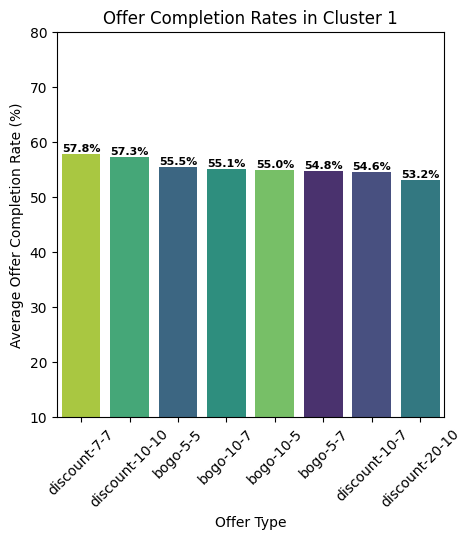

In [80]:
plot_by_cluster(1, offers)

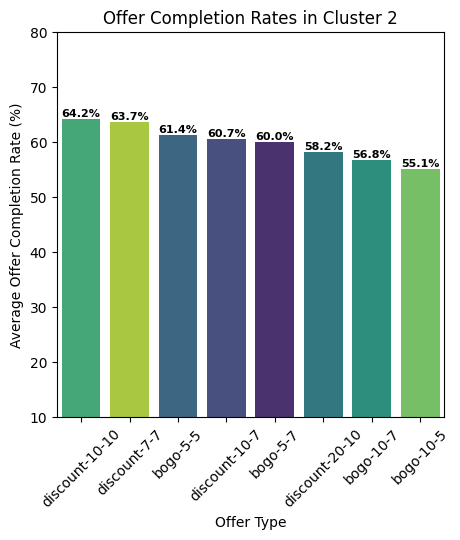

In [81]:
plot_by_cluster(2, offers)

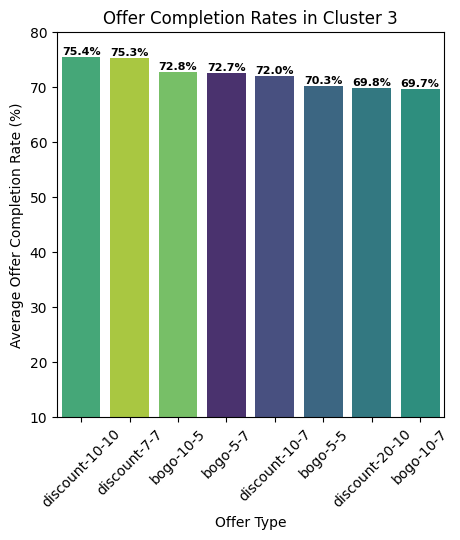

In [82]:
plot_by_cluster(3, offers)

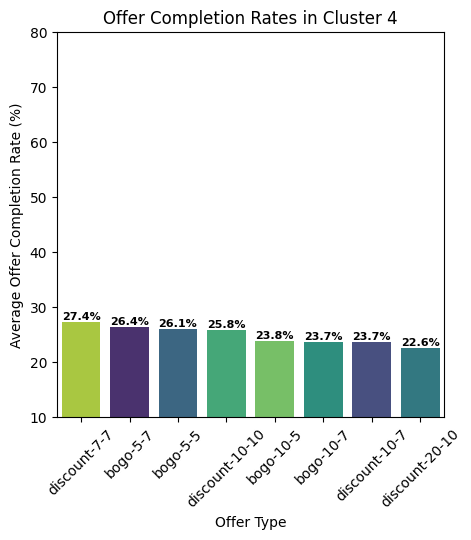

In [83]:
plot_by_cluster(4, offers)

By analyzing the plots, we can provide the following insights into the response to different offers from different customers segments:

• Top Performing Offer Across All Clusters: discount-7-7

• Underperforming Offer: discount-20-10

• Segment-Specific Success (Performs well with high-spending customers): bogo-10-5
 
• Strong Performance in Moderate and Budget Segments: bogo-5-5

• High Impact for Frequent Shoppers: discount-10-10

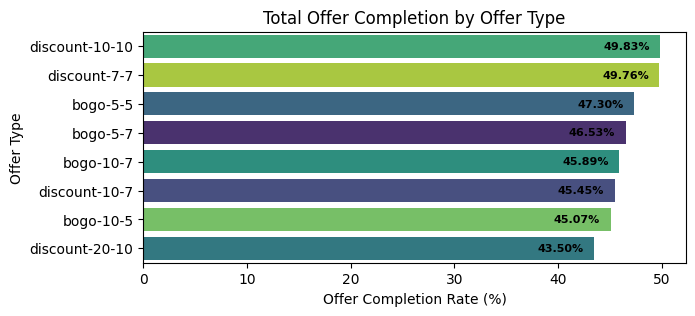

In [84]:
# Aggregate total offer completions per offer type and sort in descending order
offer_completion_total = offers.groupby('offer_type')['offer_complete_rate_%'].mean().reset_index()
offer_completion_total = offer_completion_total.sort_values(by='offer_complete_rate_%', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(7, 3))
ax = sns.barplot(
    data=offer_completion_total, 
    y='offer_type', 
    x='offer_complete_rate_%', 
    palette=[offer_type_colors[offer] for offer in offer_completion_total['offer_type']])

# Add labels to each bar
for index, value in enumerate(offer_completion_total['offer_complete_rate_%']):
    ax.text(value - 1, index, f"{value:.2f}%", va='center', ha='right', color='black', fontsize=8, fontweight='bold')
    
# Customize the plot
plt.ylabel("Offer Type")
plt.xlabel("Offer Completion Rate (%)")
plt.title("Total Offer Completion by Offer Type")
plt.grid(False)  

plt.show()

* Note: Earlier we encoded each offer with its difficulty level and duration, so 'discount-20-10' means discount with difficulty 20 and duration 10 

Analyzing offers performance across all the customer segments, we notice that discounts perform better than BOGO offers. In particular, discounts with more time to complete offers increase offer success, however very high difficulty levels reduce effectiveness. BOGO offers with moderate difficulty perform better than those with high difficulty, while the effect of duration is minimal.

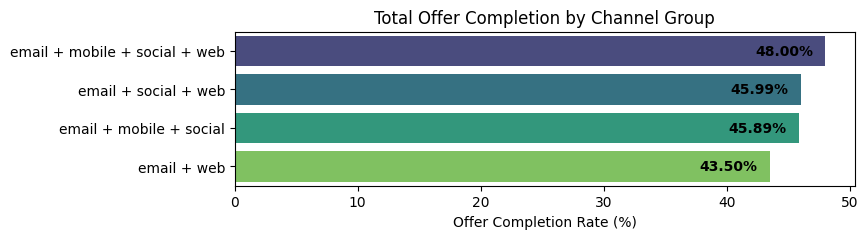

In [85]:
# Ensure channel_group is treated as a categorical variable
offers['channel_group'] = offers['channel_group'].astype(str)

# Define a mapping dictionary based on unique_combinations
channel_labels = {
    '1': 'email + mobile + social',
    '2': 'email + mobile + social + web',
    '3': 'email + social + web',
    '4': 'email + web'
}

# Aggregate total offer completions per channel group
offer_completion_total = offers.groupby('channel_group')['offer_complete_rate_%'].mean().reset_index()

# Map the numeric channel groups to meaningful labels and sort in descending order
offer_completion_total['channel_label'] = offer_completion_total['channel_group'].map(channel_labels)
offer_completion_total = offer_completion_total.sort_values(by='offer_complete_rate_%', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(8, 2))
ax = sns.barplot(
    data=offer_completion_total, 
    y='channel_label', 
    x='offer_complete_rate_%', 
    palette='viridis')

# Add labels to each bar
for index, value in enumerate(offer_completion_total['offer_complete_rate_%']):
    ax.text(value - 1, index, f"{value:.2f}%", va='center', ha='right', color='black', fontsize=10, fontweight='bold')

# Customize the plot
plt.ylabel("")
plt.xlabel("Offer Completion Rate (%)")
plt.title("Total Offer Completion by Channel Group")
plt.grid(False) 

plt.show()

Analyzing the offer completion by channel groups, we come to the conclusion that multi-channel strategy should be used to maximize reach and engagement

#### XGBoost Classifier

We will use XGBoost Classifier to build a machine learning model to predict whether a customer completes an offer. The model will be trained on 70% of the dataset and tested on the remaining 30%.

In [86]:
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix, auc, ConfusionMatrixDisplay  

In [87]:
data = offers.copy()
# Define Y (binary target)
Y = data['offer_completed'] 

x_vars = ['offer_type', 'email', 'mobile', 'social', 'web', 'gender', 'age', 'income', 'amount_spent', 
          'num_of_transactions', 'offer_complete_rate_%', 'cluster']
X = pd.get_dummies(data[x_vars], drop_first=True)

# Split Data into Training and Test Sets (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [88]:
# XGBoost Classifier 
xgb_clf = xgb.XGBClassifier(
    n_estimators=150, # more trees for stability
    max_depth=5, # reduce tree depth t prevent overfitting
    learning_rate=0.1, # slower learning for better generalization
    eval_metric="logloss", # for binary classification tasks
    random_state=42,
)

# Train the model
xgb_clf.fit(X_train, y_train)


# Make Predictions on Training and Test Data
y_train_pred_xgb = xgb_clf.predict(X_train)
y_test_pred_xgb = xgb_clf.predict(X_test)

# Compute Accuracy for Training and Test Sets
xgb_train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
xgb_test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

# Print Results
print(f"XGBoost Training Accuracy: {xgb_train_accuracy:.2f}")
print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.2f}")


XGBoost Training Accuracy: 0.89
XGBoost Test Accuracy: 0.88


The training and test accuracy show that the model has learned patterns in the data effectively and generalizes well to new data. The small gap between training and test accuracy suggests that overfitting is minimal.

However, accuracy alone may not be sufficient — it does not tell us where the model is making mistakes (false positives vs false negatives), or how it balances sensitivity and specificity. Therefore, we will next examine confusion matrix, precision/recall, and ROC curve for a better understanding.

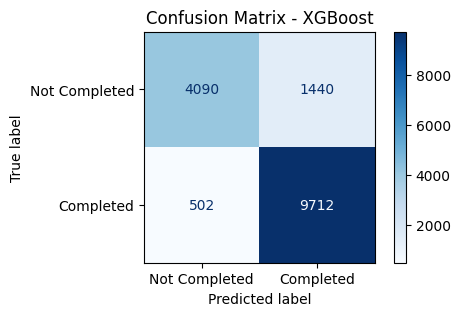

In [89]:
# Compute Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

fig, ax = plt.subplots(figsize=(5, 3))  
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Not Completed", "Completed"])
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [90]:
# Classification Report 
print("\nClassification Report - XGBoost:\n")
print(classification_report(y_test, y_test_pred_xgb))


Classification Report - XGBoost:

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      5530
           1       0.87      0.95      0.91     10214

    accuracy                           0.88     15744
   macro avg       0.88      0.85      0.86     15744
weighted avg       0.88      0.88      0.87     15744



The model is very strong at identifying customers who will complete an offer (high recall for class 1). It has a higher false positive rate (FP = 1440) than false negative (FN = 502), which means it tends to predict completion even when it doesn’t happen.

This is acceptable for our purposes, where it is less costly to falsely assume a customer will complete an offer (send a coupon they don’t use), than to miss a potential customer who would have completed an offer.

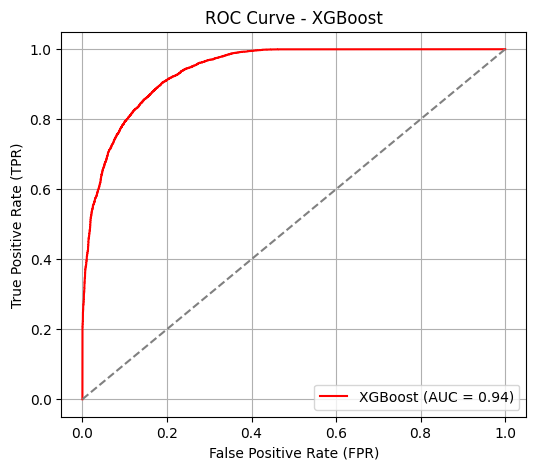

In [91]:
# Compute ROC Curve and AUC Score
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)  # Compute False Positive Rate and True Positive Rate
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.2f})", color="red")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Reference line for random guessing
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()

The ROC curve shows a steep rise at low false positive rates, indicating that the model achieves high sensitivity with minimal loss in specificity early on. However, as the threshold lowers further, gains in sensitivity come with a decline in specificity, with the false positive rate reaching 0.4 by the time the model captures all true positives. Overall, AUC of 0.94 reflects strong discriminative performance, demonstrating that the model is highly effective at ranking offers by their likelihood of completion.

In [93]:
# Get feature importances and sort them in descending order
sorted_features_xgb = sorted(zip(X.columns, xgb_clf.feature_importances_), key=lambda x: x[1], reverse=True)

print("XGBoost Feature Importances:")
for feat, imp in sorted_features_xgb:
    print(feat, imp)

XGBoost Feature Importances:
offer_complete_rate_% 0.60224295
offer_type_discount-7-7 0.06343185
offer_type_discount-10-10 0.05829427
mobile 0.052554388
web 0.03665118
offer_type_bogo-5-5 0.028668363
offer_type_bogo-5-7 0.02792404
amount_spent 0.026306067
social 0.024011353
num_of_transactions 0.02103557
cluster 0.020258388
offer_type_discount-10-7 0.013665806
income 0.010128931
gender 0.007871177
age 0.006955707
email 0.0
offer_type_bogo-10-7 0.0
offer_type_discount-20-10 0.0


The feature importance analysis reveals that offer_complete_rate_% is the most influential predictor, indicating that a customer's previous engagement is the strongest signal of future offer completion. Several offer type variations and communication channels like mobile and web also play significant roles, suggesting that both the structure of the offer and how it's delivered impact customer behavior. In contrast, static demographics like age, gender, and income had lower importance, highlighting that individual traits alone are insufficient to explain customer engagement in the rewards program.